In [1]:
from data_cleaner import basic_csv
import pandas as pd

In [2]:
user_path = 'datasets/googleplaystore_user_reviews.csv'
overall_path = 'datasets/googleplaystore.csv'

In [3]:
user_df = basic_csv(user_path)
overall_df = basic_csv(overall_path)

In [4]:
overall_df = overall_df[overall_df.Rating < 5.1]

In [5]:
overall_df.Price = overall_df.Price.apply(lambda x: x.replace('$', '')).astype('float')
overall_df.Installs = overall_df.Installs.apply(lambda x: x.replace('+', '')).apply(lambda x: x.replace(',', '')).astype('int')

In [6]:
overall_df['Content Rating'].value_counts()

Everyone           7420
Teen               1084
Mature 17+          461
Everyone 10+        397
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64

In [7]:
user_df.Sentiment.value_counts()

Positive    23998
Negative     8271
Neutral      5163
Name: Sentiment, dtype: int64

In [8]:
overall_df.drop_duplicates('App', inplace=True)

In [9]:
overall_df.Size.value_counts()

Varies with device    1169
14M                    149
12M                    146
11M                    144
13M                    143
                      ... 
442k                     1
292k                     1
499k                     1
787k                     1
782k                     1
Name: Size, Length: 414, dtype: int64

In [10]:
merging_df = overall_df.drop('Size', axis=1).drop('Type', axis=1)

In [11]:
merging_df.Reviews = merging_df.Reviews.astype('int')

In [12]:
merging_df2 = user_df.groupby('App').mean()

In [13]:
merging_df2.dropna(inplace=True)

In [14]:
merging_df.set_index('App', inplace=True)

In [15]:
# merging_df.set_index('App', inplace=True)

combined_df = merging_df.join(merging_df2, how='outer',)

In [16]:
combined_df.shape 

(8245, 12)

In [17]:
combined_df.dropna(inplace=True)

In [18]:
combined_df['Content Rating'].value_counts()

Everyone           652
Teen                87
Mature 17+          47
Everyone 10+        29
Adults only 18+      1
Name: Content Rating, dtype: int64

In [19]:
combined_df.drop('Category', axis=1, inplace=True)

In [20]:
combined_df

,Rating,Reviews,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Sentiment_Polarity,Sentiment_Subjectivity
App,,,,,,,,,,,
10 Best Foods for You,4.0,2490.0,500000.0,0.0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up,0.470733,0.495455
11st,3.8,48732.0,10000000.0,0.0,Everyone,Shopping,"July 31, 2018",7.8.1,4.0 and up,0.181294,0.443957
1800 Contacts - Lens Store,4.7,23160.0,1000000.0,0.0,Everyone,Medical,"July 27, 2018",7.4.1,5.0 and up,0.318145,0.591098
1LINE – One Line with One Touch,4.6,214878.0,10000000.0,0.0,Everyone,Board,"August 3, 2018",2.0.4,4.1 and up,0.196290,0.557315
2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,4.2,115773.0,10000000.0,0.0,Everyone,Personalization,"May 22, 2018",Varies with device,4.1 and up,0.449566,0.520573
...,...,...,...,...,...,...,...,...,...,...,...
Hotels.com: Book Hotel Rooms & Find Vacation Deals,4.5,260121.0,10000000.0,0.0,Everyone,Travel & Local,"July 4, 2018",Varies with device,Varies with device,0.101622,0.545444
Hotspot Shield Free VPN Proxy & Wi-Fi Security,4.2,1116393.0,50000000.0,0.0,Everyone,Tools,"August 6, 2018",6.1.0,4.1 and up,0.251765,0.393284
Hotstar,4.3,4885646.0,100000000.0,0.0,Teen,Entertainment,"August 3, 2018",Varies with device,Varies with device,0.038178,0.493964


In [21]:
import scipy.stats as stats

combined_df['boxcox_reviews'] = stats.boxcox(combined_df.Reviews)[0]
combined_df['boxcox_rating'] = stats.boxcox(combined_df.Rating)[0]
combined_df['boxcox_installs'] = stats.boxcox(combined_df.Installs)[0]

In [22]:
combined_df.drop('Reviews',axis=1,inplace=True)
combined_df.drop('Rating', axis=1, inplace=True)
combined_df.drop('Price', axis=1, inplace=True)

In [23]:
import matplotlib.pyplot as plt

pd.plotting.scatter_matrix(combined_df, figsize=(24,8))
plt.show();

<Figure size 2400x800 with 36 Axes>

In [45]:
# combined_df['log_installs'] = np.log(combined_df['Installs'])

In [46]:
# combined_df.drop('Installs', axis=1, inplace=True)

In [24]:
combined_df

,Installs,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_reviews,boxcox_rating,boxcox_installs
App,,,,,,,,,,,
10 Best Foods for You,500000.0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up,0.470733,0.495455,7.374914,346.522155,13.745769
11st,10000000.0,Everyone,Shopping,"July 31, 2018",7.8.1,4.0 and up,0.181294,0.443957,9.958354,262.094657,17.065360
1800 Contacts - Lens Store,1000000.0,Everyone,Medical,"July 27, 2018",7.4.1,5.0 and up,0.318145,0.591098,9.323017,833.525703,14.507654
1LINE – One Line with One Touch,10000000.0,Everyone,Board,"August 3, 2018",2.0.4,4.1 and up,0.196290,0.557315,11.204375,741.465653,17.065360
2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,10000000.0,Everyone,Personalization,"May 22, 2018",Varies with device,4.1 and up,0.449566,0.520573,10.688417,451.927587,17.065360
...,...,...,...,...,...,...,...,...,...,...,...
Hotels.com: Book Hotel Rooms & Find Vacation Deals,10000000.0,Everyone,Travel & Local,"July 4, 2018",Varies with device,Varies with device,0.101622,0.545444,11.362813,657.876488,17.065360
Hotspot Shield Free VPN Proxy & Wi-Fi Security,50000000.0,Everyone,Tools,"August 6, 2018",6.1.0,4.1 and up,0.251765,0.393284,12.555758,451.927587,18.877827
Hotstar,100000000.0,Teen,Entertainment,"August 3, 2018",Varies with device,Varies with device,0.038178,0.493964,13.738121,513.675983,19.664745


In [25]:
combined_df_cat = combined_df['Content Rating']

In [26]:
target = combined_df['boxcox_installs']
features = combined_df.iloc[:,6:9]
whole = pd.concat([features, target], axis=1)

In [27]:
whole

,Android Ver,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_reviews,boxcox_installs
App,,,,,
10 Best Foods for You,2.3.3 and up,0.470733,0.495455,7.374914,13.745769
11st,4.0 and up,0.181294,0.443957,9.958354,17.065360
1800 Contacts - Lens Store,5.0 and up,0.318145,0.591098,9.323017,14.507654
1LINE – One Line with One Touch,4.1 and up,0.196290,0.557315,11.204375,17.065360
2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,4.1 and up,0.449566,0.520573,10.688417,17.065360
...,...,...,...,...,...
Hotels.com: Book Hotel Rooms & Find Vacation Deals,Varies with device,0.101622,0.545444,11.362813,17.065360
Hotspot Shield Free VPN Proxy & Wi-Fi Security,4.1 and up,0.251765,0.393284,12.555758,18.877827
Hotstar,Varies with device,0.038178,0.493964,13.738121,19.664745


In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# ss_df = pd.DataFrame(scaler.fit_transform(features),index=features.index, columns=features.columns)
ss_df = pd.DataFrame(scaler.fit_transform(whole), index=whole.index, columns=whole.columns)

In [54]:
import seaborn as sns
ss_df.corr()

,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_reviews,boxcox_rating,log_installs
Sentiment_Polarity,1.000000,0.319732,-0.191458,0.244924,-0.220348
Sentiment_Subjectivity,0.319732,1.000000,0.055535,0.205513,-0.006016
boxcox_reviews,-0.191458,0.055535,1.000000,0.280680,0.898328
boxcox_rating,0.244924,0.205513,0.280680,1.000000,0.117327
log_installs,-0.220348,-0.006016,0.898328,0.117327,1.000000


In [55]:
import numpy as np

ss_df = ss_df[(np.abs(stats.zscore(ss_df)) < 2).all(axis=1)]

In [56]:
dummies_df = pd.get_dummies(combined_df_cat, drop_first=True)

In [57]:
feature_df = ss_df.join(dummies_df)

In [70]:
feature_df2 = feature_df.drop('boxcox_reviews', axis=1)

In [71]:
feature_df2

,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_rating,log_installs,Everyone,Everyone 10+,Mature 17+,Teen
App,,,,,,,,
10 Best Foods for You,1.675664,0.041458,-1.033459,-0.691834,0,1,0,0
11st,-0.118915,-0.563531,-1.503225,0.625158,1,0,0,0
1800 Contacts - Lens Store,0.729587,1.165069,1.676295,-0.387111,1,0,0,0
1LINE – One Line with One Touch,-0.025936,0.768189,1.164061,0.625158,1,0,0,0
2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,1.544425,0.336544,-0.446969,0.625158,1,0,0,0
...,...,...,...,...,...,...,...,...
Hotels.com: Book Hotel Rooms & Find Vacation Deals,-0.612897,0.628727,0.698959,0.625158,1,0,0,0
Hotspot Shield Free VPN Proxy & Wi-Fi Security,0.318017,-1.158827,-0.446969,1.332704,1,0,0,0
Hotstar,-1.006265,0.023947,-0.103392,1.637427,0,0,0,1


In [74]:
target = feature_df2['log_installs']
feature = feature_df2.drop('log_installs', axis=1)

In [75]:
feature

,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_rating,Everyone,Everyone 10+,Mature 17+,Teen
App,,,,,,,
10 Best Foods for You,1.675664,0.041458,-1.033459,0,1,0,0
11st,-0.118915,-0.563531,-1.503225,1,0,0,0
1800 Contacts - Lens Store,0.729587,1.165069,1.676295,1,0,0,0
1LINE – One Line with One Touch,-0.025936,0.768189,1.164061,1,0,0,0
2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,1.544425,0.336544,-0.446969,1,0,0,0
...,...,...,...,...,...,...,...
Hotels.com: Book Hotel Rooms & Find Vacation Deals,-0.612897,0.628727,0.698959,1,0,0,0
Hotspot Shield Free VPN Proxy & Wi-Fi Security,0.318017,-1.158827,-0.446969,1,0,0,0
Hotstar,-1.006265,0.023947,-0.103392,0,0,0,1


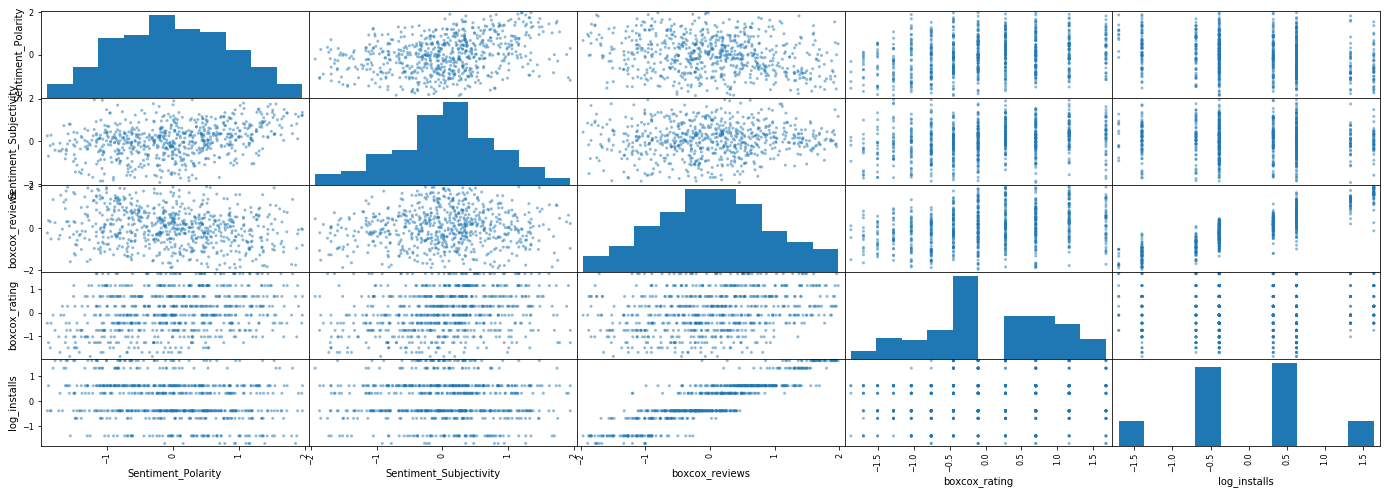

In [61]:
pd.plotting.scatter_matrix(feature_df.iloc[:,0:5], figsize=(24,8));

# Done with the data processing.

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = .2)

In [77]:
train_df = pd.concat([X_train,y_train],axis=1)

In [78]:
train_df.rename(columns={'Everyone 10+':'Everyone10', 'Mature 17+':'Mature17'}, inplace=True)

In [79]:
train_df

,Sentiment_Polarity,Sentiment_Subjectivity,boxcox_rating,Everyone,Everyone10,Mature17,Teen,log_installs
App,,,,,,,,
Calendar+ Schedule Planner App,0.735327,-0.260593,-1.033459,1,0,0,0,-0.387111
Binaural Beats Meditation,0.948909,0.850481,-0.103392,1,0,0,0,-1.704103
HD Camera for Android,1.089488,0.632520,-0.756077,1,0,0,0,0.625158
All-in-One Mahjong 3 FREE,1.857126,1.269643,0.698959,1,0,0,0,-1.704103
AirAsia,-1.885356,-0.699750,-1.281698,1,0,0,0,0.625158
...,...,...,...,...,...,...,...,...
Firefox Browser fast & private,-0.560073,0.315554,0.277559,1,0,0,0,1.637427
Ecobank Mobile Banking,-1.335111,0.583250,-1.033459,1,0,0,0,-0.387111
Bloomberg: Market & Financial News,-0.903791,-1.808701,-0.446969,1,0,0,0,0.625158


In [80]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

x_columns = '+'.join(train_df.columns[:-1])

f = f'log_installs ~ {x_columns}'

model = ols(formula=f, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_installs   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     9.111
Date:                Mon, 06 Jan 2020   Prob (F-statistic):           1.19e-10
Time:                        18:02:25   Log-Likelihood:                -642.78
No. Observations:                 541   AIC:                             1302.
Df Residuals:                     533   BIC:                             1336.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2906      0.801     -0.363      0.717      -1.863       1.282
Sentiment_Polarity        -0.3076      0.044     -6.988      0.000      -0.394      -0.221
Sentiment_Subjectivity     0.0086      0.047      0.182      0.856      -0.084       0.101
boxcox_rating              0.1629      0.041      3.937      0.000       0.082       0.244
Everyone                   0.3095      0.801      0.386      0.700      -1.265       1.884
Everyone10                -0.0398      0.827     -0.048      0.962      -1.665       1.586
Mature17                   0.0646      0.816      0.079      0.937      -1.539       1.668
Teen                       0.3879      0.808      0.480      0.632      -1.200       1.976
==============================================================================
Omnibus:                       14.634   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.938
Skew:                          -0.076   Prob(JB):                       0.0189
Kurtosis:                       2.427   Cond. No.                         69.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

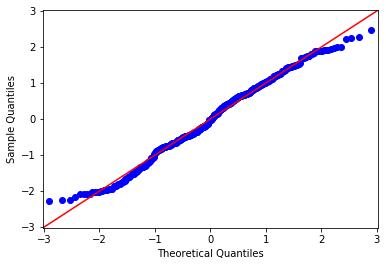

In [83]:
import scipy.stats as stats

residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45',fit=True)